In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/occupancy-detection/datatest.csv
/kaggle/input/occupancy-detection/datatrain.csv


# Step 1: Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import warnings

from xgboost import XGBClassifier, plot_importance 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier
import eli5
from eli5.sklearn import PermutationImportance


from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense

In [3]:
warnings.filterwarnings('ignore')

In [4]:
# Load datasets
df_train = pd.read_csv('/kaggle/input/occupancy-detection/datatrain.csv')
df_test = pd.read_csv('/kaggle/input/occupancy-detection/datatest.csv')

# Step 2: Data Exploration

In [5]:
df_train.head()

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,1,02/04/15 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2,02/04/15 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,3,02/04/15 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,4,02/04/15 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,5,02/04/15 17:55,23.10,27.2000,426.0,704.50,0.004757,1


In [6]:
df_train.shape

(17895, 8)

In [7]:
df_test.head()

,id,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,140,02/02/15 14:19,23.7000,26.272,585.200000,749.200000,0.004764,1
1,141,02/02/15 14:19,23.7180,26.290,578.400000,760.400000,0.004773,1
2,142,02/02/15 14:21,23.7300,26.230,572.666667,769.666667,0.004765,1
3,143,02/02/15 14:22,23.7225,26.125,493.750000,774.750000,0.004744,1
4,144,02/02/15 14:23,23.7540,26.200,488.600000,779.000000,0.004767,1


In [8]:
df_test.shape

(2665, 8)

In [9]:
# Join both datasets
df = pd.concat([df_train, df_test], axis=0)

In [10]:
df.shape

(20560, 8)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             20560 non-null  int64  
 1   date           20560 non-null  object 
 2   Temperature    20560 non-null  float64
 3   Humidity       20560 non-null  float64
 4   Light          20560 non-null  float64
 5   CO2            20560 non-null  float64
 6   HumidityRatio  20560 non-null  float64
 7   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 1.4+ MB


In [12]:
# Convert date column to datetime type
df['date'] = pd.to_datetime(df['date'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20560 entries, 0 to 2664
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             20560 non-null  int64         
 1   date           20560 non-null  datetime64[ns]
 2   Temperature    20560 non-null  float64       
 3   Humidity       20560 non-null  float64       
 4   Light          20560 non-null  float64       
 5   CO2            20560 non-null  float64       
 6   HumidityRatio  20560 non-null  float64       
 7   Occupancy      20560 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 1.4 MB


In [14]:
df.isna().sum()

id               0
date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [15]:
df = df.drop(columns=['id'])

<Axes: title={'center': 'Correlation Heatmap'}>

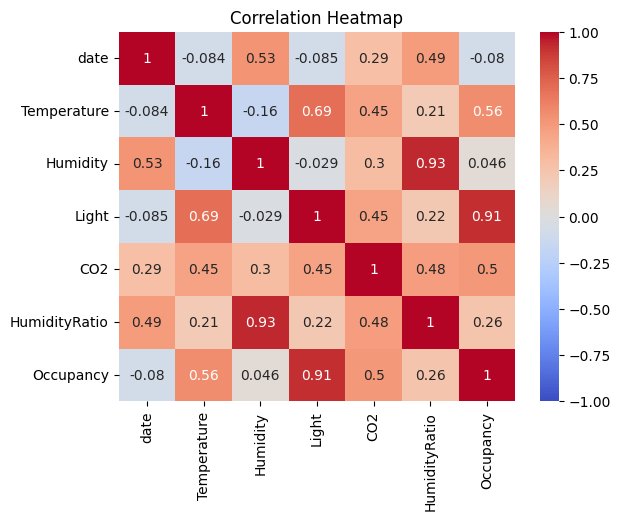

In [16]:
# Correlation heatmap
plt.title('Correlation Heatmap')
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)

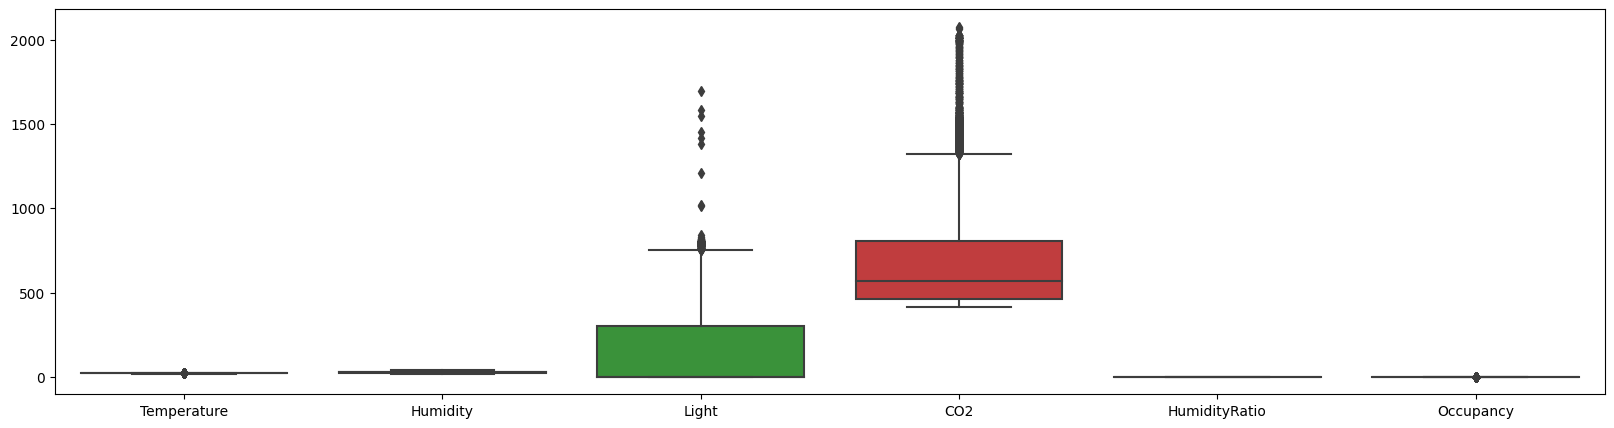

In [17]:
fig = plt.figure(figsize=(20,5))
sns.boxplot(df)
plt.show()

<Axes: xlabel='Light', ylabel='Count'>

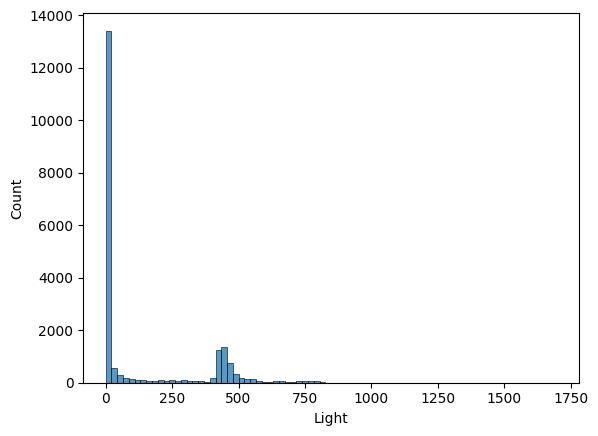

In [18]:
sns.histplot(df['Light'])

<Axes: xlabel='CO2', ylabel='Count'>

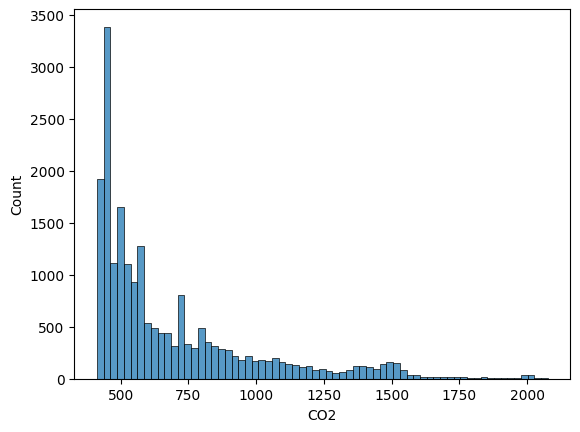

In [19]:
sns.histplot(df['CO2'])

<Axes: xlabel='HumidityRatio', ylabel='Count'>

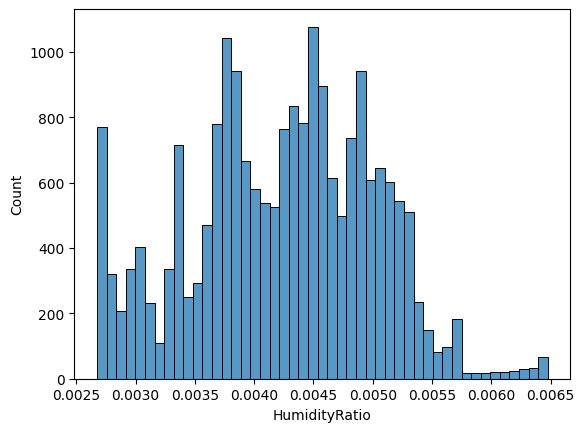

In [20]:
sns.histplot(df['HumidityRatio'])

In [21]:
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:00,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [22]:
# Check the class distribution
df['Occupancy'].value_counts(normalize=True)

Occupancy
0    0.768969
1    0.231031
Name: proportion, dtype: float64

In [23]:
# Extract year, month, date etc from date column
df['date'] = pd.to_datetime(df['date'])
df['year'] =df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day_name()
df['weekday'] =df['date'].dt.weekday

In [24]:
df.groupby(['day','Occupancy'])[['Occupancy']].count()

Occupancy
day       Occupancy           
Friday    0               1800
          1               1080
Monday    0               2173
          1               1288
Saturday  0               2880
Sunday    0               2880
Thursday  0               2097
          1                783
Tuesday   0               2264
          1               1190
Wednesday 0               1716
          1                409

In [25]:
# Replace day_name with day number
df['day'] = df['date'].dt.day 

# Step 3: Model Building & Evaluation

In [26]:
#Create X and y sets
X = df.copy()
X = X.drop(['date','Occupancy'], axis=1)

y = df['Occupancy']

In [27]:
X.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,year,month,day,weekday
0,23.18,27.2720,426.0,721.25,0.004793,2015,2,4,2
1,23.15,27.2675,429.5,714.00,0.004783,2015,2,4,2
2,23.15,27.2450,426.0,713.50,0.004779,2015,2,4,2
3,23.15,27.2000,426.0,708.25,0.004772,2015,2,4,2
4,23.10,27.2000,426.0,704.50,0.004757,2015,2,4,2


In [28]:
# Apply MinMax scaler
sc = MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 1. XGBoost Classifier

In [30]:
# Train XGBclassifier
xgb = XGBClassifier(enable_categorical=True)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# Make predictions and evaluate performance
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print('F1 score', f1_score(y_test, y_pred))
print('Recall score',recall_score(y_test, y_pred))
print('Precision score', precision_score(y_test, y_pred))

Accuracy: 0.9919747081712063
F1 score 0.9829457364341085
Recall score 0.9885654885654885
Precision score 0.9773895169578622


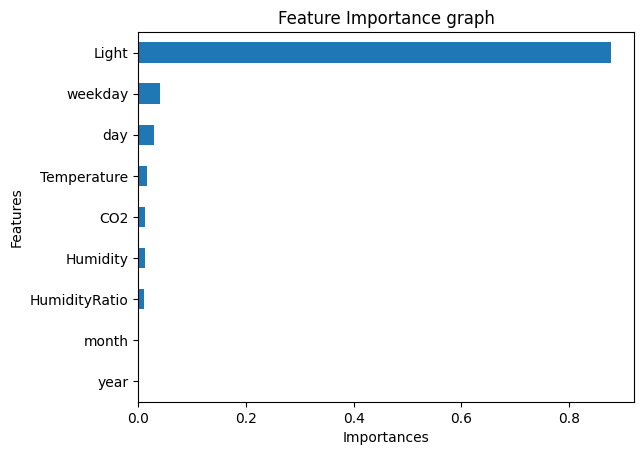

In [32]:
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
plt.title('Feature Importance graph')
feat_importances.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.show()
# plot_importance(clf)

In [33]:
import gzip
import pickle
filename = 'xgb_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(xgb, f)    # aquí seleccionamos el modelo

# Aquí probamos que sí funcione
# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)



## 2. Random Forest Classifier

In [34]:
rfc = RandomForestClassifier(n_estimators=300, random_state=42)

In [35]:
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=42)

In [36]:
y_pred = rfc.predict(X_test)
 
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))
print('Recall score',recall_score(y_test, y_pred))
print('Precision score', precision_score(y_test, y_pred))

Accuracy: 0.9914883268482491
F1 score 0.9818746763335059
Recall score 0.9854469854469855
Precision score 0.978328173374613


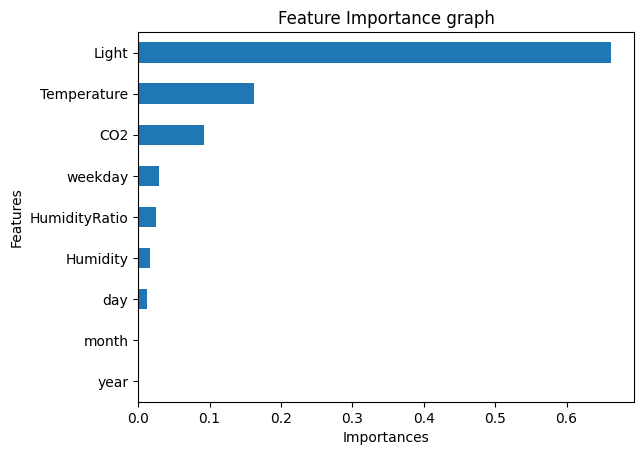

In [37]:
feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.title('Feature Importance graph')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.show()

In [38]:
import gzip
import pickle
filename = 'random_forest_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(rfc, f)    # aquí seleccionamos el modelo

# Aquí probamos que sí funcione
# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)



## 3. Decision Tree Classifier

In [39]:
dt = DecisionTreeClassifier(max_depth=None, random_state=0)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))
print('Recall score',recall_score(y_test, y_pred))
print('Precision score', precision_score(y_test, y_pred))

Accuracy: 0.9897859922178989
F1 score 0.9781704781704782
Recall score 0.9781704781704782
Precision score 0.9781704781704782


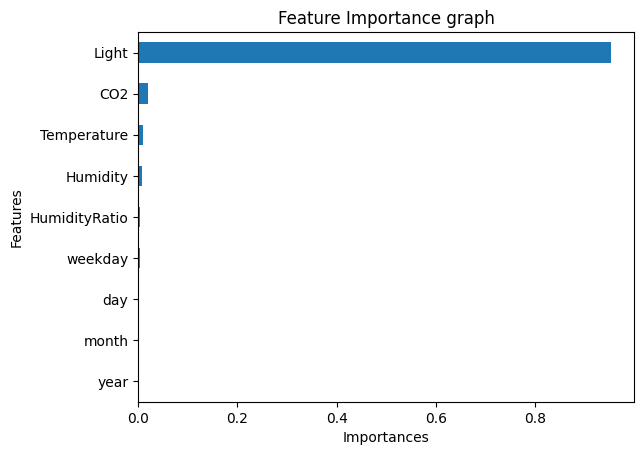

In [40]:
feat_importances = pd.Series(dt.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.title('Feature Importance graph')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.show()

In [41]:


import gzip
import pickle
filename = 'decision_tree_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(dt, f)    # aquí seleccionamos el modelo

# Aquí probamos que sí funcione
# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)

## 4. K-Nearest Neighbor classifier

In [42]:
# Try different number of neighbors and see scores.
for n in [3, 5, 7, 9, 11, 13, 15]:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Evaluate the model
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    print(f'Accuracy for {n} neighbors is: {accuracy}')
    print(f'F1 for {n} neighbors is: {f1}')
    print('')

Accuracy for 3 neighbors is: 0.9922178988326849
F1 for 3 neighbors is: 0.9833679833679834

Accuracy for 5 neighbors is: 0.9922178988326849
F1 for 5 neighbors is: 0.9834368530020703

Accuracy for 7 neighbors is: 0.9907587548638133
F1 for 7 neighbors is: 0.9803516028955533

Accuracy for 9 neighbors is: 0.9900291828793775
F1 for 9 neighbors is: 0.9788332472896232

Accuracy for 11 neighbors is: 0.9895428015564203
F1 for 11 neighbors is: 0.9778236204228985

Accuracy for 13 neighbors is: 0.9888132295719845
F1 for 13 neighbors is: 0.9763130792996911

Accuracy for 15 neighbors is: 0.9890564202334631
F1 for 15 neighbors is: 0.9768637532133676



In [43]:
# nearest neighbor=7 has highest f1 score and accuracy score. Choose 7 neighbors and run KNN
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test,y_pred)
print(f'Accuracy for 7 neighbors is: {accuracy}')
print(f'F1 for 7 neighbors is: {f1}')
print(f'Recall for 7 neighbors is: {recall}')
print(f'Precision for 7 neighbors is: {precision}')

Accuracy for 7 neighbors is: 0.9907587548638133
F1 for 7 neighbors is: 0.9803516028955533
Recall for 7 neighbors is: 0.9854469854469855
Precision for 7 neighbors is: 0.9753086419753086


In [44]:
perm = PermutationImportance(knn, random_state=42)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
0.2761 ± 0.0049,Light
0.0458 ± 0.0037,weekday
0.0148 ± 0.0021,Temperature
0.0145 ± 0.0019,CO2
0.0108 ± 0.0026,day
0.0075 ± 0.0018,HumidityRatio
0.0057 ± 0.0015,Humidity
0 ± 0.0000,month
0 ± 0.0000,year


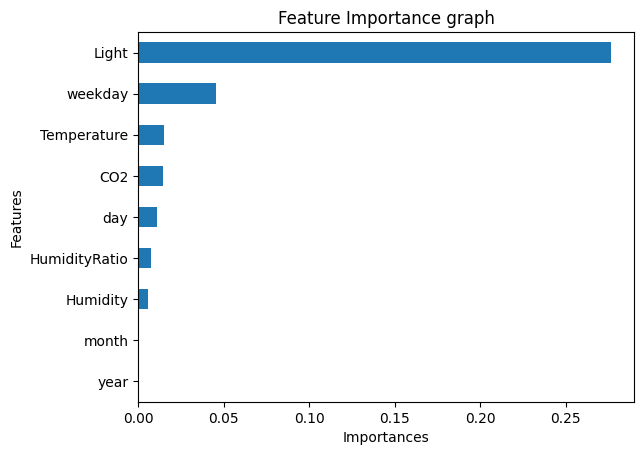

In [45]:
importances = perm.feature_importances_

feat_importances = pd.Series(importances, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)
feat_importances.plot(kind='barh')
plt.title('Feature Importance graph')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.show()

In [46]:

import gzip
import pickle
filename = 'knn_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(knn, f)    # aquí seleccionamos el modelo

# Aquí probamos que sí funcione
# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)

In [47]:
X_train.shape

(16448, 9)

In [48]:
# Define the keras model and train on training data
# RNN with 4 layers :- 
# Input Layer: This is implicitly defined by the input_shape parameter in the first Dense layer.
# First Dense Layer: Dense(32, input_shape=(input_dim,), activation='relu')
# Second Dense Layer: Dense(16, activation='relu')
# Output Layer: Dense(1, activation='sigmoid')

model = Sequential()
model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

clf = model.fit(X_train, y_train, epochs=50, batch_size=500, verbose=0) 
# verbose=0 will not show each step in training(i.e. each epoch's accuracy and loss)


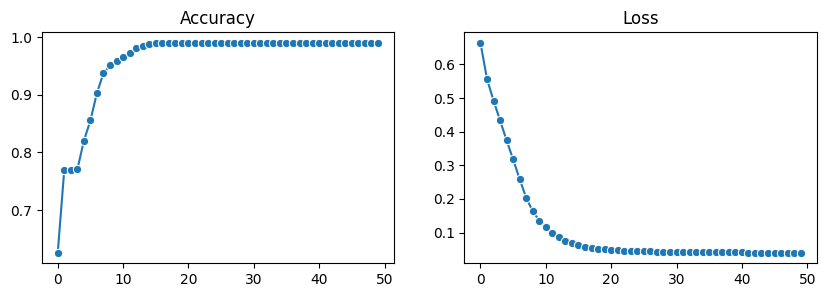

In [49]:
# Get the summary/history of epochs
accuracy = clf.history['accuracy']
loss = clf.history['loss']

# Plot the loss and accuracy on graph to see visually
fig, axes = plt.subplots(1,2, figsize=(10,3)) 
sns.lineplot(accuracy, marker='o', ax=axes[0])
sns.lineplot(loss, marker='o', ax=axes[1])
axes[0].set_title('Accuracy')
axes[1].set_title('Loss')
plt.show()

In [50]:

import gzip
import pickle
filename = 'keras_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(model, f)    # aquí seleccionamos el modelo

# Aquí probamos que sí funcione
# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)

In [51]:
# Evaluate the model on test set
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy of model on test data:', round((accuracy*100),2),'%')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0379
Accuracy of model on test data: 99.0 %


In [52]:
# 1️ Instalación automática de wandb si no está instalado
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

try:
    import wandb
except ImportError:
    !pip install wandb
    import wandb

#  2️Iniciar sesión con API Key (sin intervención manual)
wandb.login(key="b716e94c63bf46b77de0a98d87adcedb6c4bfb70")  #  Reemplaza con tu clave real

# 3️Cargar dependencias necesarias
from wandb.integration.keras import WandbCallback
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# 4️ Cargar y normalizar datos MNIST
#(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

# 5️ Definir configuración del Sweep con q_normal en batch_size
sweep_config = {
    "method": "random",  # Métodos: "grid", "random", "bayes"
    "metric": {"name": "val_loss", "goal": "minimize"},  # Minimizar val_loss
    "parameters": {
        "epochs": {"distribution": "int_uniform", "min": 5, "max": 6},
        "batch_size": {"distribution": "q_normal", "mu": 64, "sigma": 32, "q": 8},
        "learning_rate": {"distribution": "log_uniform_values", "min": 0.0001, "max": 0.1},
        "num_units": {"distribution": "q_normal", "mu": 128, "sigma": 32, "q": 16},  #  Media 128, sigma 32, paso 16
        "depth": {"distribution": "int_uniform", "min": 1, "max": 5},  #  Número de capas ocultas aleatorio
        "activation": {"values": ["relu", "tanh", "sigmoid"]},  #  Valores discretos
        "optimizer": {"values": ["adam", "sgd", "rmsprop"]}  # Valores discretos
    }
}

project_name= "prueba_occupancy"

# 6️ Crear el Sweep en wandb sin logs innecesarios
sweep_id = wandb.sweep(sweep_config, project=project_name)

# 7️ Definir la función de entrenamiento
def train():
    wandb.init(settings=wandb.Settings(_disable_stats=True, silent=True))  #  Desactivar logs de wandb
    config = wandb.config  # Obtener los hiperparámetros del Sweep

    # Construcción del modelo sin Dropout
    model = keras.Sequential([layers.Flatten(input_shape=(9,))])
    for _ in range(config.depth):
        model.add(layers.Dense(config.num_units, activation=config.activation))  #  Activación configurable
    model.add(layers.Dense(10, activation="softmax"))

    optimizer = {
        "adam": keras.optimizers.Adam(learning_rate=config.learning_rate),
        "sgd": keras.optimizers.SGD(learning_rate=config.learning_rate),
        "rmsprop": keras.optimizers.RMSprop(learning_rate=config.learning_rate)
    }[config.optimizer]

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Evitar el guardado del modelo en WandB
    class CustomWandbCallback(WandbCallback):
        def _save_model_as_artifact(self, *args, **kwargs):
            pass  #  Desactiva el guardado automático del modelo

    # Entrenar el modelo sin verbose
    history = model.fit(
        X_train, y_train,
        epochs=config.epochs,
        batch_size=config.batch_size,
        validation_data=(X_test, y_test),
        verbose=1,  #  Desactiva verbose de Keras
        callbacks=[CustomWandbCallback(log_model=False, save_graph=False, save_code=False)]
    )

    # Evaluar el modelo sin verbose
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)  #  Desactiva verbose

    # Registrar métricas adicionales
    wandb.log({
        "test_accuracy": test_acc,
        "test_loss": test_loss,
        "epochs": config.epochs,
        "batch_size": config.batch_size,  # Ahora batch_size se genera con q_normal
        "learning_rate": config.learning_rate,
        "num_units": config.num_units,
        "depth": config.depth,
        "activation": config.activation,
        "optimizer": config.optimizer
    })
    wandb.finish()  # Finalizar experimento
# 8️ Ejecutar el Sweep sin logs innecesarios
wandb.agent(sweep_id, function=train, count=3)  #  Desactivar logs de wandb.agent
print(" Sweeps completados. Revisa los resultados en: https://wandb.ai")


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: juanpablonore (juanpablonore-universidad-nacional-de-colombia). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: jclf2qq8
Sweep URL: https://wandb.ai/juanpablonore-universidad-nacional-de-colombia/prueba_occupancy/sweeps/jclf2qq8


wandb: Agent Starting Run: 1qj2hvxp with config:
wandb: 	activation: relu
wandb: 	batch_size: 24
wandb: 	depth: 1
wandb: 	epochs: 6
wandb: 	learning_rate: 0.000301946264609411
wandb: 	num_units: 192
wandb: 	optimizer: rmsprop
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7548 - loss: 1.1167 - val_accuracy: 0.9326 - val_loss: 0.2048
Epoch 2/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9503 - loss: 0.1673 - val_accuracy: 0.9774 - val_loss: 0.0937
Epoch 3/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9798 - loss: 0.0849 - val_accuracy: 0.9888 - val_loss: 0.0602
Epoch 4/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9873 - loss: 0.0648 - val_accuracy: 0.9932 - val_loss: 0.0436
Epoch 5/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9899 - loss: 0.0508 - val_accuracy: 0.9929 - val_loss: 0.0384
Epoch 6/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9883 - loss: 0.0560 - val_accuracy: 0.9929 - val_loss: 0.0362


wandb:                                                                                
wandb: Agent Starting Run: w9n9d27v with config:
wandb: 	activation: tanh
wandb: 	batch_size: -24
wandb: 	depth: 4
wandb: 	epochs: 6
wandb: 	learning_rate: 0.00954657683354044
wandb: 	num_units: 80
wandb: 	optimizer: rmsprop
wandb:                                                                                
Run w9n9d27v errored:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
    self._function()
  File "<ipython-input-52-2ba9bb8d96ce>", line 75, in train
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py", line 1037, in _create_c_op
    raise ValueError(e.message)
ValueError: Invalid value in tensor 

Epoch 1/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7704 - loss: 1.3641 - val_accuracy: 0.7714 - val_loss: 0.7513
Epoch 2/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7678 - loss: 0.7174 - val_accuracy: 0.7714 - val_loss: 0.6358
Epoch 3/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7607 - loss: 0.6384 - val_accuracy: 0.7714 - val_loss: 0.5985
Epoch 4/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7707 - loss: 0.5940 - val_accuracy: 0.7714 - val_loss: 0.5808
Epoch 5/5
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7723 - loss: 0.5769 - val_accuracy: 0.7714 - val_loss: 0.5710


wandb:                                                                                


 Sweeps completados. Revisa los resultados en: https://wandb.ai


In [53]:
# veamos los modelos que se entrenaron
wandb.init()

api = wandb.Api()

# Obtener la lista de proyectos
projects = api.projects()
print("Proyectos disponibles:", [p.name for p in projects])

# Obtener todas las ejecuciones del proyecto
runs = api.runs(f"{wandb.run.entity}/{project_name}")

# Encontrar la mejor ejecución basada en la menor val_loss
best_run = min(runs, key=lambda run: run.summary.get("val_loss", float("inf")))

# Obtener los mejores hiperparámetros
best_hyperparams = best_run.config
print("Mejores hiperparámetros encontrados:", best_hyperparams)


wandb: WARNING Changes to your `wandb` environment variables will be ignored because your `wandb` session has already started. For more information on how to modify your settings with `wandb.init()` arguments, please refer to https://wandb.me/wandb-init.
wandb: Tracking run with wandb version 0.19.1
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250208_170048-vyid02ii
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run youthful-sweep-3
wandb: ⭐️ View project at https://wandb.ai/juanpablonore-universidad-nacional-de-colombia/prueba_occupancy
wandb: 🧹 View sweep at https://wandb.ai/juanpablonore-universidad-nacional-de-colombia/prueba_occupancy/sweeps/jclf2qq8
wandb: 🚀 View run at https://wandb.ai/juanpablonore-universidad-nacional-de-colombia/prueba_occupancy/runs/vyid02ii


Proyectos disponibles: ['prueba_occupancy', 'mnist']
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Mejores hiperparámetros encontrados: {'depth': 1, 'epochs': 6, 'num_units': 192, 'optimizer': 'rmsprop', 'activation': 'relu', 'batch_size': 24, 'learning_rate': 0.000301946264609411}


In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import numpy as np

# Construcción del modelo con los mejores hiperparámetros
model = keras.Sequential([layers.Flatten(input_shape=(9,))])
for _ in range(best_hyperparams["depth"]):
    model.add(layers.Dense(best_hyperparams["num_units"], activation=best_hyperparams["activation"]))
model.add(layers.Dense(10, activation="softmax"))

# Definir optimizador
optimizer = {
    "adam": keras.optimizers.Adam(learning_rate=best_hyperparams["learning_rate"]),
    "sgd": keras.optimizers.SGD(learning_rate=best_hyperparams["learning_rate"]),
    "rmsprop": keras.optimizers.RMSprop(learning_rate=best_hyperparams["learning_rate"])
}[best_hyperparams["optimizer"]]

# Compilar modelo
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar modelo
model.fit(
    X_train, y_train,
    epochs=best_hyperparams["epochs"],
    batch_size=best_hyperparams["batch_size"],
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7577 - loss: 1.0704 - val_accuracy: 0.9382 - val_loss: 0.1999
Epoch 2/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9558 - loss: 0.1594 - val_accuracy: 0.9793 - val_loss: 0.0890
Epoch 3/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9787 - loss: 0.0884 - val_accuracy: 0.9920 - val_loss: 0.0558
Epoch 4/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9889 - loss: 0.0600 - val_accuracy: 0.9932 - val_loss: 0.0441
Epoch 5/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9899 - loss: 0.0518 - val_accuracy: 0.9932 - val_loss: 0.0407
Epoch 6/6
686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9897 - loss: 0.0505 - val_accuracy: 0.9932 - val_loss: 0.0373


In [55]:
import gzip
import pickle

# best_model
# Guardar el modelo comprimido
filename = 'best_model.pkl.gz'
with gzip.open(filename, 'wb') as f:
    pickle.dump(model, f)

# Cargar el modelo comprimido
with gzip.open(filename, 'rb') as f:
    loaded_model = pickle.load(f)

# Evaluar el modelo cargado
result = loaded_model.evaluate(X_test, y_test)
print(f"Accuracy del modelo cargado: {result[-1]}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9959 - loss: 0.0295
Accuracy del modelo cargado: 0.9931906461715698
